## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from datetime import date
import requests

from scipy.stats import poisson

import nba_api
from nba_api.stats.static import teams
from nba_api.stats.endpoints import leaguegamefinder
from nba_api.stats.static import players
from nba_api.stats.endpoints import playergamelog
from nba_api.stats.endpoints import teamgamelogs
from nba_api.stats.endpoints import teamandplayersvsplayers

import emcee
import corner

import seaborn as sns
sns.set()

## Let's pull some team/game info from the NBA API

In [2]:
#2015-2016 regular season start and end dates
start_15_16 = '2015-10-27'
end_15_16 = '2016-04-13'

#2016-2017 regular season start and end dates
start_16_17 = '2016-10-25'
end_16_17 = '2017-04-12'

#2016-2017 regular season start and end dates
start_17_18 = '2017-10-17'
end_17_18 = '2018-04-11'

#2018-2019 regular season start and end dates
start_18_19 = '2018-10-16'
end_18_19 = '2019-04-10'

In [3]:
teams_df = pd.DataFrame(teams.get_teams())
teams_df.rename(columns={'id':'TEAM_ID'}, inplace=True)
teams_df.head()

,abbreviation,city,full_name,TEAM_ID,nickname,state,year_founded
0,ATL,Atlanta,Atlanta Hawks,1610612737,Hawks,Atlanta,1949
1,BOS,Boston,Boston Celtics,1610612738,Celtics,Massachusetts,1946
2,CLE,Cleveland,Cleveland Cavaliers,1610612739,Cavaliers,Ohio,1970
3,NOP,New Orleans,New Orleans Pelicans,1610612740,Pelicans,Louisiana,2002
4,CHI,Chicago,Chicago Bulls,1610612741,Bulls,Illinois,1966


In [4]:
# Get **all** the games so we can filter to an individual GAME_ID
result = leaguegamefinder.LeagueGameFinder()
all_games = result.get_data_frames()[0]
all_games.head()

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS
0,22019,1612709911,IWA,Iowa Wolves,2021900026,2020-03-15,IWA @ MHU,None,107,41,...,0.833,2,15,17,8,1,7,11,8,-16.2
1,22019,1612709926,MHU,Memphis Hustle,2021900026,2020-03-15,MHU vs. IWA,None,120,56,...,1.000,7,17,24,13,5,1,4,7,15.6
2,22019,1612709917,GRD,Grand Rapids Drive,2021900565,2020-03-11,GRD vs. FWN,L,240,103,...,0.500,17,33,50,31,14,2,16,20,-13.0
3,22019,1610612765,DET,Detroit Pistons,0021900971,2020-03-11,DET @ PHI,L,241,106,...,0.680,6,26,32,25,10,3,8,24,-14.2
4,22019,1612709905,SBL,South Bay Lakers,2021900569,2020-03-11,SBL vs. AUS,W,240,148,...,0.824,12,29,41,30,6,1,17,21,10.0


In [5]:
#match NBA teams from 'teams_df' with 'all_games' to remove
#all non NBA-games from 'all_games' 
nba_games = pd.merge(teams_df, all_games, on = 'TEAM_ID', how = 'inner')
nba_games.head()

,abbreviation,city,full_name,TEAM_ID,nickname,state,year_founded,SEASON_ID,TEAM_ABBREVIATION,TEAM_NAME,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS
0,ATL,Atlanta,Atlanta Hawks,1610612737,Hawks,Atlanta,1949,22019,ATL,Atlanta Hawks,...,0.808,15,38,53,26,6,3,17,25,0.0
1,ATL,Atlanta,Atlanta Hawks,1610612737,Hawks,Atlanta,1949,22019,ATL,Atlanta Hawks,...,0.593,12,41,53,33,1,5,15,26,5.0
2,ATL,Atlanta,Atlanta Hawks,1610612737,Hawks,Atlanta,1949,22019,ATL,Atlanta Hawks,...,0.857,14,32,46,23,9,2,14,24,-17.0
3,ATL,Atlanta,Atlanta Hawks,1610612737,Hawks,Atlanta,1949,22019,ATL,Atlanta Hawks,...,0.667,6,30,36,25,9,4,17,25,-6.0
4,ATL,Atlanta,Atlanta Hawks,1610612737,Hawks,Atlanta,1949,22019,ATL,Atlanta Hawks,...,0.938,16,27,43,20,6,8,17,21,-39.0


In [6]:
#function searches rows in 'nba_games' df sharing same 'GAME_ID' and sums PTS
#to obtain sum of final score
def total_pts_game(id_game):
    return np.sum(nba_games.loc[nba_games['GAME_ID'] == str(id_game)][['PTS']])

In [7]:
#uses 'total_pts_game' function to create df of sum of final score for
#all games in 'nba_games' df
total_points = pd.DataFrame(list(map(lambda x : total_pts_game(nba_games['GAME_ID'][x]), list(range(len(nba_games))))))

In [8]:
#appends new column to 'nba_games' df containing combined final score per game
nba_games['COMBINED_FINAL_SCORE'] = total_points
nba_games.head()

,abbreviation,city,full_name,TEAM_ID,nickname,state,year_founded,SEASON_ID,TEAM_ABBREVIATION,TEAM_NAME,...,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS,COMBINED_FINAL_SCORE
0,ATL,Atlanta,Atlanta Hawks,1610612737,Hawks,Atlanta,1949,22019,ATL,Atlanta Hawks,...,15,38,53,26,6,3,17,25,0.0,267
1,ATL,Atlanta,Atlanta Hawks,1610612737,Hawks,Atlanta,1949,22019,ATL,Atlanta Hawks,...,12,41,53,33,1,5,15,26,5.0,281
2,ATL,Atlanta,Atlanta Hawks,1610612737,Hawks,Atlanta,1949,22019,ATL,Atlanta Hawks,...,14,32,46,23,9,2,14,24,-17.0,219
3,ATL,Atlanta,Atlanta Hawks,1610612737,Hawks,Atlanta,1949,22019,ATL,Atlanta Hawks,...,6,30,36,25,9,4,17,25,-6.0,230
4,ATL,Atlanta,Atlanta Hawks,1610612737,Hawks,Atlanta,1949,22019,ATL,Atlanta Hawks,...,16,27,43,20,6,8,17,21,-39.0,215


In [9]:
#mask to filter dates within range
mask_15_16 = (nba_games['GAME_DATE'] >= start_15_16) & (nba_games['GAME_DATE'] <= end_15_16)
mask_16_17 = (nba_games['GAME_DATE'] >= start_16_17) & (nba_games['GAME_DATE'] <= end_16_17)
mask_17_18 = (nba_games['GAME_DATE'] >= start_17_18) & (nba_games['GAME_DATE'] <= end_17_18)
mask_18_19 = (nba_games['GAME_DATE'] >= start_18_19) & (nba_games['GAME_DATE'] <= end_18_19)

In [10]:
#regular season games held between given seasons
nba_games_15_16 = nba_games.loc[mask_15_16]
nba_games_16_17 = nba_games.loc[mask_16_17]
nba_games_17_18 = nba_games.loc[mask_17_18]
nba_games_18_19 = nba_games.loc[mask_18_19]

In [11]:
nba_games_15_16.head()

,abbreviation,city,full_name,TEAM_ID,nickname,state,year_founded,SEASON_ID,TEAM_ABBREVIATION,TEAM_NAME,...,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS,COMBINED_FINAL_SCORE
377,ATL,Atlanta,Atlanta Hawks,1610612737,Hawks,Atlanta,1949,22015,ATL,Atlanta Hawks,...,9,38,47,22,13,5,22,21,-11.0,207
378,ATL,Atlanta,Atlanta Hawks,1610612737,Hawks,Atlanta,1949,22015,ATL,Atlanta Hawks,...,10,32,42,23,8,6,15,18,-15.0,203
379,ATL,Atlanta,Atlanta Hawks,1610612737,Hawks,Atlanta,1949,22015,ATL,Atlanta Hawks,...,5,39,44,31,10,10,17,22,11.0,225
380,ATL,Atlanta,Atlanta Hawks,1610612737,Hawks,Atlanta,1949,22015,ATL,Atlanta Hawks,...,5,36,41,23,4,12,13,19,8.0,182
381,ATL,Atlanta,Atlanta Hawks,1610612737,Hawks,Atlanta,1949,22015,ATL,Atlanta Hawks,...,13,37,50,26,16,3,16,21,13.0,193


## Our model
We propose a model where the likelihood of team A scoring N points in a game is given by a Poisson Distribution

$$p(N|\mu_A) = \frac{ \mu_A^N e^{-\mu_A} }{N!}$$

where $\mu_A$ is an effective parameter that contains information regarding the teams average points per game, the opposing teams defensive capabilities, and potentially other factors....

For instance, for the amount of points team A will score, we can take 
$$\mu_A = \mu_{A0} * (1-d_B),$$

$\mu_{A0}$ : controls the average number of points that team A would score against a team with very poor defense $d_B = 0$

$d_B$ : the 'defense efficiency' of team B.

In this case, every team has 2 parameters, and so a model for predicting $M$ teams will require at least $2M$ parameters...

Since we are interested in predicting the total number of points in the game by both teams, we can use the fact that that if $Z = X + Y$, and $X \sim p(N|\mu = \mu_X)$, $Y \sim p(N|\mu = \mu_Y)$ are Poisson, then $Z$ is also Poisson $Z \sim p(N|\mu = \mu_X + \mu_Y)$.

If we treat each game as being statistically independent,
then the likelihood of $M$ games is the product of each game's likelihood:

$$p(N_1|\mu_1)p(N_2|\mu_2)... = \prod_i p(N_i|\mu_i) = L(N_i|\mu_i)$$
where $N_i$ total points were scored in game $i$, and game $i$ was played by two teams satisfying $\mu_i = \mu_{iA} + \mu_{iB}$.

The logarithm of the likelihood satisfies
$$\ln L(N_i|\mu_i) = \sum_i \ln p(N_i|\mu_i)$$

We can (later) try to incorporate additional features which we believe could be important as model parameters.
For instance, the teams scoring rate and/or defensive effficiency could be multiplied by a 'travel factor', etc...

### Lets try it with a subset of teams...

In [12]:
n_teams = 3
n_parameters_per_team = 2

team_ids = nba_games_15_16['TEAM_ID'].unique()
#print(team_ids)
selected_teams = team_ids[0:n_teams]
print(selected_teams)

[1610612737 1610612738 1610612739]


## Our Prior for the model parameters

We know that a team will average somewhere between 60 and 130 points per game,
so it seems reasonable to take uniform prior for each team to have a mean score in this range.

Finally, a team with a defensive efficiency of either 0 (very bad) or 1 (does not allow opposing team to score at all) both seem unlikely, however we can take a uniform prior for d between 0 and 1. Later we can see if a more restrictive prior is justifed. 

In [13]:
#our Prior
#all teams are assumed to have the same scoring and defensive parameters a priori
min_score = 60.
max_score = 160.

min_defense = 0.1
max_defense = 1.

min_mu = np.ones(n_teams) * min_score
max_mu = np.ones(n_teams) * max_score
min_d = np.ones(n_teams) * min_defense
max_d = np.ones(n_teams) * max_defense

#take a uniform prior
min_theta = np.concatenate( (min_mu, min_d) )
max_theta = np.concatenate( (max_mu, max_d) )
volume_theta = np.prod(max_theta-min_theta)

def log_prior(theta):
    '''Log prior for parameter array theta'''
    if np.logical_and(min_theta<=theta, theta<=max_theta).all(): 
        return np.log(1./volume_theta)
    else:
        return -np.inf 

### Our Likelihood Function
See the description above.


In [14]:
def log_likelihood(mu, d, game_tot_pts, team1, team2):
    """
    The logarithm of the likelihood function of M games.
    Assuming there are t teams,
    mu : (array of length t) scoring parameters for each team,
    d : (array of length t) defense efficiency parameters for each team,
    game_tot_pts : (array of length M) total points scored in each game,
    team1 : (array of length M) index of team1 in each game,
    team2 : (array of length M) index of team2 in each game.
    """
    n_games = len(game_tot_pts)
    ln_p = 0.
    
    theta = np.concatenate( (mu, d) )
    
    if np.logical_and(min_theta<=theta, theta<=max_theta).all(): 
        try:
            for i in range(n_games):
                tot_pts = game_tot_pts[i]
                team1_idx = np.where(selected_teams == team1[i])
                team2_idx = np.where(selected_teams == team2[i])
    
                mu_eff = mu[ team1_idx ] * (1. - d[ team2_idx ]) + mu[ team2_idx ] * (1. - d[ team1_idx ])
                ln_p += poisson.logpmf(tot_pts, mu_eff)
            return ln_p
        except ValueError:
            return -np.inf
    else:
        return -np.inf

In [15]:
def log_posterior(theta, game_tot_pts, team1, team2):
    '''Log posterior for data given parameter array theta'''
    #split theta into scoring and defensive efficiencies
    mu = theta[:n_teams]
    d = theta[n_teams:]
    try:
        return log_prior(theta) + log_likelihood(mu, d, game_tot_pts, team1, team2)
    except ValueError:
        return -np.inf

# We need to collect our historical data

In [16]:
#get all games for which these 3 teams played each other
game_tot_pts = np.array([])
team_1_list = np.array([])
team_2_list = np.array([])

for i, team_1 in enumerate(selected_teams):
    team_1_abb = teams_df[ teams_df['TEAM_ID'] == team_1 ]['abbreviation'].values[0]
    mask_team1 = nba_games_15_16['TEAM_ABBREVIATION'] == team_1_abb
    games_team1 = nba_games_15_16.loc[mask_team1]
    
    remaining_teams = np.delete(selected_teams, i)
    for j, team_2 in enumerate(remaining_teams):
        team_2_abb = teams_df[ teams_df['TEAM_ID'] == team_2 ]['abbreviation'].values[0]
        match_games = games_team1[games_team1['MATCHUP'].str.contains(team_2_abb)]
        game_tot_pts = np.append(game_tot_pts, match_games['COMBINED_FINAL_SCORE'].values)
        n_games = match_games.shape[0]
        for game in range(n_games):
            team_1_list = np.append(team_1_list, np.array([team_1]))
            team_2_list = np.append(team_2_list, np.array([team_2]))
print("len of game_tot_pts : " + str(len(game_tot_pts)))
print("len of team_1_list : " + str(len(team_1_list)))
print("len of team_1_list : " + str(len(team_2_list)))

len of game_tot_pts : 20
len of team_1_list : 20
len of team_1_list : 20


In [17]:
ndim = n_teams*n_parameters_per_team  # number of parameters in the model
nwalkers = ndim*20 # number of MCMC walkers
nburn = 1000  # "burn-in" period to let chains stabilize
nsteps = 1000  # number of MCMC steps to take
nthreads = 2

print("Number teams : " + str(n_teams))
print("Number parameters per team : " + str(n_parameters_per_team))

# we'll start at random locations within the prior volume
starting_guesses = min_theta + \
                   (max_theta - min_theta) * np.random.rand(nwalkers, ndim)

print("MCMC sampling using emcee (affine-invariant ensamble sampler) with {0} walkers".format(nwalkers))
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, 
                                args=[game_tot_pts, team_1_list, team_2_list],
                                threads = nthreads)
# "burn-in" period; save final positions and then reset
pos, prob, state = sampler.run_mcmc(starting_guesses, nburn)
sampler.reset()
# sampling period
sampler.run_mcmc(pos, nsteps)
print("Mean acceptance fraction: {0:.3f} (in total {1} steps)"
                .format(np.mean(sampler.acceptance_fraction),nwalkers*nsteps))
# discard burn-in points and flatten the walkers; the shape of samples is (nwalkers*nsteps, ndim)
samples = sampler.chain.reshape((-1, ndim))

Number teams : 3
Number parameters per team : 2
MCMC sampling using emcee (affine-invariant ensamble sampler) with 120 walkers
Mean acceptance fraction: 0.376 (in total 120000 steps)


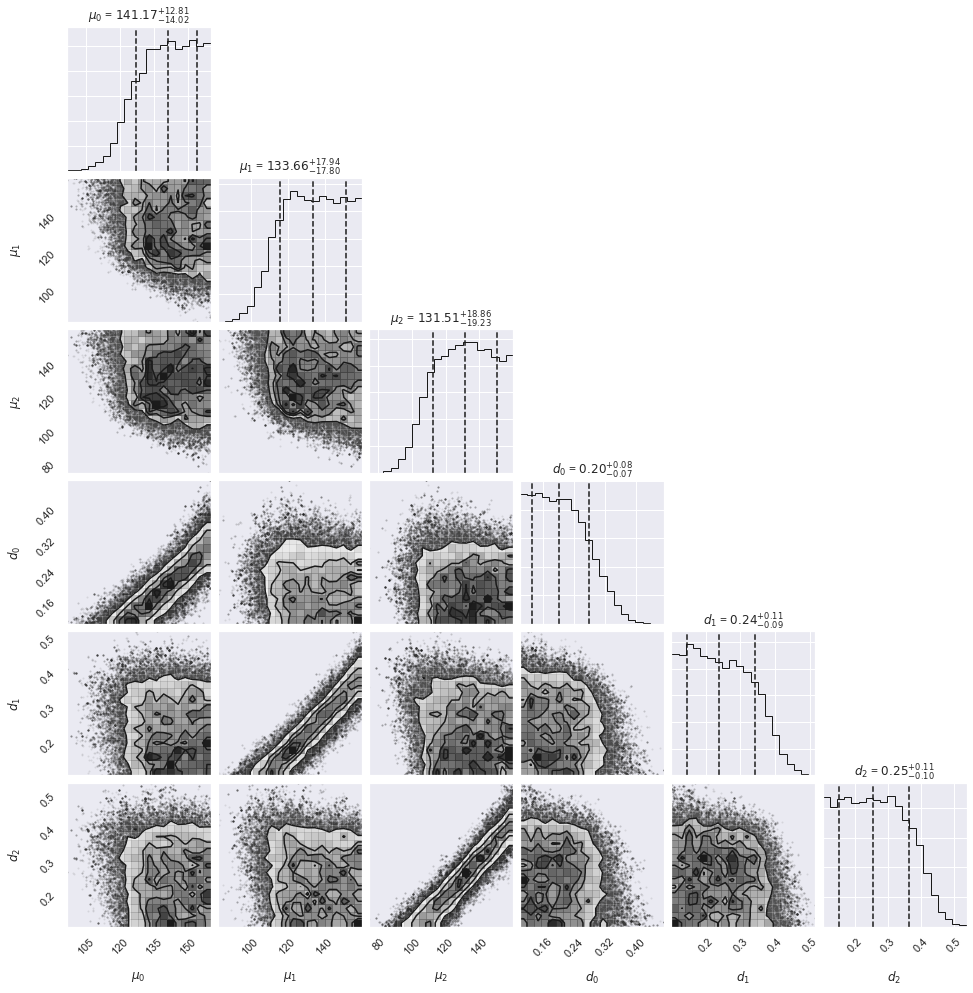

In [18]:
# make a corner plot with the posterior distribution
chain_labels = []
for i in range(n_teams):
    chain_labels.append(r'$\mu_{:}$'.format(i) )
for i in range(n_teams):
    chain_labels.append(r'$d_{:}$'.format(i) )
    
fig = corner.corner(samples, 
                    labels=chain_labels, 
                    quantiles=[0.16, 0.5, 0.84],
                    show_titles=True, title_kwargs={"fontsize": 12})

## Old Stuff Below...

### Exploring use of Poisson distribution analytically

In [ ]:
def team_mean_pts_per_game(team_id):
    mask = (nba_games_15_16['TEAM_ID'] == team_id)
    team_df = nba_games_15_16.loc[mask]
    mu = team_df['PTS'].mean()
    return mu

In [ ]:
mu_ATL = team_mean_pts_per_game(team_id=1610612737)
print("ATL mean points per game : " + str(round(mu_ATL, 2)))

### We can model points by each team individually as Poisson
$\rm Pois(\mu = \mu_1)$ for team 1, $\rm Pois(\mu = \mu_2)$ for team 2


Then, the total number of points is distributed as $\rm Pois(\mu = \mu_1 + \mu_2)$

In [ ]:
#let's try some specific games
team_1 = 1610612737
team_2 = 1610612738

mu_1 = team_mean_pts_per_game(team_id=team_1)
mu_2 = team_mean_pts_per_game(team_id=team_2)
mu_t = mu_1 + mu_2

tot_pts_possible = np.linspace(0, 400, 401)
prob_lt_t = poisson.cdf(tot_pts_possible, mu_t)
prob_gt_t = np.ones_like(prob_lt_t) - prob_lt_t
plt.plot(tot_pts_possible, prob_gt_t)
plt.xlabel(r'$t$')
plt.ylabel(r'$p($total points $ \geq t)$')
plt.title('CDF')
plt.show()

In [ ]:
#try for a pair of teams
team_1 = 1610612737
team_2 = 1610612738

team_1_abb = teams_df[ teams_df['TEAM_ID'] == team_1 ]['abbreviation'].values[0]
team_2_abb = teams_df[ teams_df['TEAM_ID'] == team_2 ]['abbreviation'].values[0]

print("team_1 : " + team_1_abb)
print("team_2 : " + team_2_abb)

mu_1 = team_mean_pts_per_game(team_id=team_1)

print("Mean points per game team_1 : " + str(mu_1))
    
mask_team1 = nba_games_15_16['TEAM_ABBREVIATION'] == team_1_abb
games_team1 = nba_games_15_16.loc[mask_team1]
       
mu_2 = team_mean_pts_per_game(team_id=team_2)
print("Mean points per game team_2 : " + str(mu_2))

mu_t = mu_1 + mu_2
prob_lt_t = poisson.cdf(tot_pts_possible, mu_t)
prob_gt_t = np.ones_like(prob_lt_t) - prob_lt_t

match_games = games_team1[games_team1['MATCHUP'].str.contains(team_2_abb)]
display(match_games)

In [ ]:
#now lets try looping over all pairs of teams
tot_pts_possible = np.linspace(0, 400, 401)

for team_1 in team_ids:
    team_1_abb = teams_df[ teams_df['TEAM_ID'] == team_1 ]['abbreviation'].values[0]

    mu_1 = team_mean_pts_per_game(team_id=team_1)
    
    mask_team1 = nba_games_15_16['TEAM_ABBREVIATION'] == team_1_abb
    games_team1 = nba_games_15_16.loc[mask_team1]
    
    for team_2 in team_ids:
        team_2_abb = teams_df[ teams_df['TEAM_ID'] == team_2 ]['abbreviation'].values[0]
        
        mu_2 = team_mean_pts_per_game(team_id=team_2)
        mu_t = mu_1 + mu_2
        prob_lt_t = poisson.cdf(tot_pts_possible, mu_t)
        prob_gt_t = np.ones_like(prob_lt_t) - prob_lt_t
        
        match_games = games_team1[games_team1['MATCHUP'].str.contains(team_2_abb)]

## Trying a more complicated model than Univariate Poisson
Poisson for each team assumes that each team scores are independent of their opponent, which is a bit naive. When a team plays an opponent with strong defense, they will score less...

references : 

https://pdfs.semanticscholar.org/87b1/f65f8dc33d5f6ec33ce04df49e9b159038d3.pdf

https://gawhitaker.github.io/project.pdf

